# Analisis regional utilizando Geoplots

En esta sección se analizarán algunos datos según las regiones que aparecen en el set de datos.

In [2]:
import geopandas
import geoplot
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

plt.style.use('default') # haciendo los graficos un poco mas bonitos en matplotlib
#plt.rcParams['figure.figsize'] = (20, 10)

sns.set(style="whitegrid") # seteando tipo de grid en seaborn

pd.options.display.float_format = '{:20,.2f}'.format # suprimimos la notacion cientifica en los outputs

Para poder realizar esto, se hizo uso de la libreria 'Geopandas' y 'Geoplot' la cuál permite realizar gráficos en determinadas regiones, complementando a pandas con GeoSeries y GeoDataFrames. Para comenzar, veremos la cantidad de registros que se generaron en todo el dataframe, a nivel global.

C:\Users\Juan\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Text(116,0.5,'Latitud')

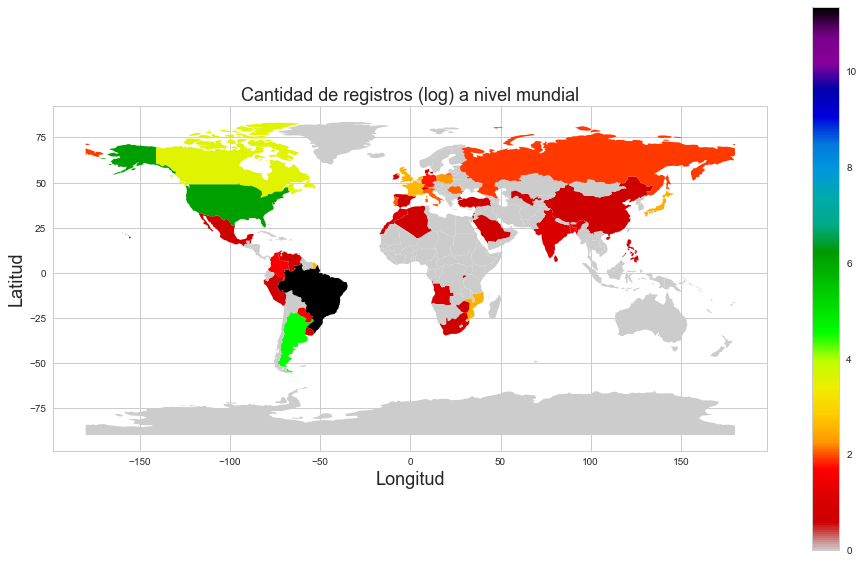

In [3]:
#GeoDataFrame global
path = geopandas.datasets.get_path('naturalearth_lowres')
df_geo = geopandas.read_file(path)

df = pd.read_csv('events.csv')

df_countries = df[['country']].dropna()
df_countries['counter'] = 1

aux = df_countries.groupby('country')
aux = aux.agg('sum')

df_geo = df_geo.rename(columns = {'name' : 'country'})

df_geo = df_geo.merge(aux, on='country', how='left')
df_geo = df_geo.fillna(0)

#Ploteamos el logaritmo de la cantidad de registros por la amplia diferencia
#entre Brasil y el resto del mundo
df_geo['counter_log'] = np.log(df_geo["counter"]+1)

graph = df_geo.plot(figsize=(16,10), column='counter_log', \
                   cmap='nipy_spectral_r', legend=True, k=100)
graph.set_title('Cantidad de registros (log) a nivel mundial', fontsize=18)
graph.set_xlabel("Longitud",fontsize=18)
graph.set_ylabel("Latitud", fontsize=18)

A partir de la visualizacion anterior, se pueden rescatar los siguientes datos:
1. Trocafone tiene más popularidad en America que en otras regiones del mundo.
2. Debido a su origen, Brasil es el pais con mayor cantidad de registros, seguido por Estados Unidos y Argentina.
3. No se obtuvieron registros de Oceania ni de la mayor parte de África.

Dado que observamos que la mayor cantidad de registros provienen de Brasil y Estados Unidos, será conveniente entonces realizar un analisis similar pero focalizado en estos dos paises.

## Cantidad de registros por región en Brasil

C:\Users\Juan\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Text(201.212,0.5,'Latitud')

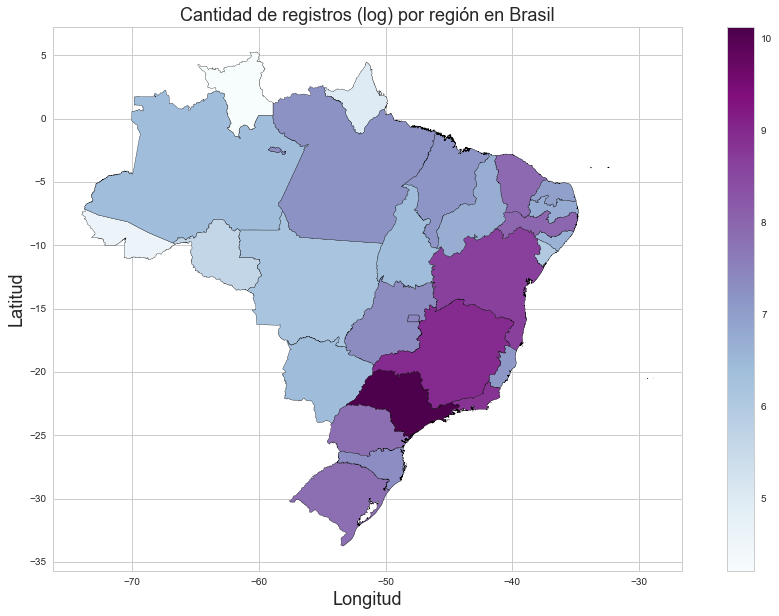

In [4]:
#Cargo el GeoDataFrame de Brasil
brazil_gdf = geopandas.read_file('brasil_shp/gadm36_BRA_1.shp') #gdf = GeoDataFrame

#Normalizo los str de las regiones ya que contienen tildes y otros caracteres
brazil_gdf['NAME_1'] = brazil_gdf['NAME_1'].str.normalize('NFKD')\
            .str.encode('ascii', errors='ignore').str.decode('utf-8')

#Cargo el DataFrame de Trocafone            
df = pd.read_csv('events.csv')

df_brazil = df.loc[df['country'] == 'Brazil', ['region','country']]
df_brazil = df_brazil.loc[df_brazil['region'].notnull(), :]
df_brazil = df_brazil.loc[~df_brazil['region'].isin(['Unknown']), :]
df_brazil['region'] = df_brazil['region'].str.normalize('NFKD')\
                .str.encode('ascii',errors='ignore').str.decode('utf-8')

#Pequeña corrección para luego joinear. Federal District --> Distrito Federal
df_brazil = df_brazil.replace(to_replace='Federal District', \
                              value='Distrito Federal')
df_brazil['counter'] = df_brazil['region'].isin(brazil_gdf.NAME_1)
df_brazil = df_brazil.groupby('region').sum()
df_brazil = df_brazil.reset_index()
df_brazil = df_brazil.rename(columns={'region':'NAME_1'})
brazil_gdf = brazil_gdf.merge(df_brazil, on='NAME_1', how='left')

#Debido a la gran diferencia de registros de Sao Paulo con el resto, ploteamos log
brazil_gdf['counter_log'] = np.log(brazil_gdf["counter"]+1)

graph = brazil_gdf.plot(column='counter_log',edgecolor='black', legend=True, \
                 cmap='BuPu', figsize=(16,10))

graph.set_title('Cantidad de registros (log) por región en Brasil', fontsize=18)
graph.set_xlabel("Longitud",fontsize=18)
graph.set_ylabel("Latitud", fontsize=18)

A partir del gráfico, se puede extraer que las regiones donde Trocafone es mas popular son Sao Paulo, Minas Gerais, Bahia, Pernambuco, Ceará y Rio Grande do Sul. Es también entendible por ser las zonas mas habitadas del pais (el estado de Sao Paulo es el que mayor habitantes tiene en toda la región, con un total de, aproximadamente, 45 millones de habitantes). A partir de esta información es que se podria recomendar hacer incapié en el desarrollo de la empresa en dichas regiones.

## Cantidad de registros por región en Estados Unidos

C:\Users\Juan\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Text(121.875,0.5,'Latitud')

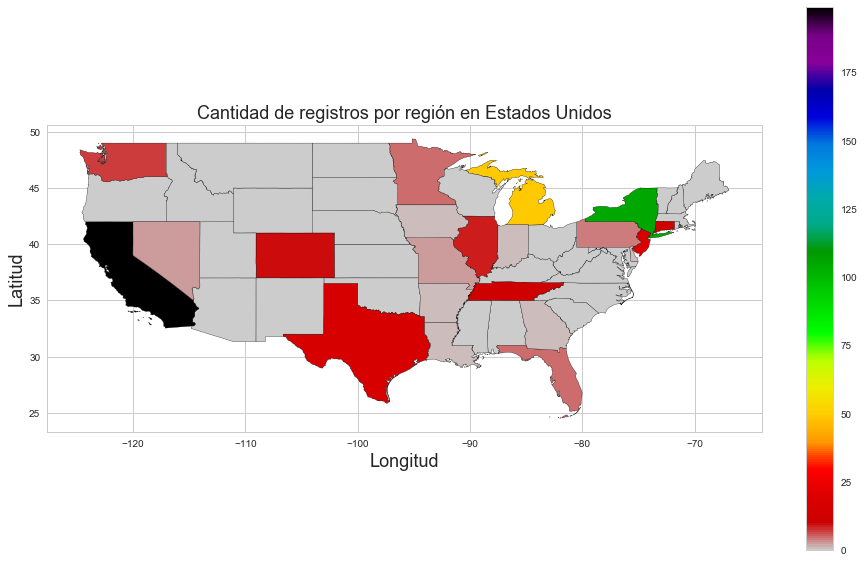

In [5]:
usa_gdf = geopandas.read_file('usa_shp/cb_2017_us_state_5m.shp')
df = pd.read_csv('events.csv')
df_just_usa = df.loc[df['country'] == 'United States', ['region', 'country']]
df_just_usa['counter'] = 1
df_just_usa = df_just_usa.groupby('region').agg('sum')
df_just_usa = df_just_usa.reset_index()
df_just_usa = df_just_usa.rename(columns = {'region' : 'NAME'})
usa_gdf = usa_gdf.merge(df_just_usa,on='NAME', how='left')
usa_gdf = usa_gdf.fillna(0)

#Quitamos algunos sectores del mapa, como Hawaii o Alaska, para que el plot
#sea mas prolijo. Ninguno de estos sectores aparece en el dataset
usa_gdf = usa_gdf[usa_gdf.STATEFP.astype(int) < 60]
usa_gdf = usa_gdf[~usa_gdf.NAME.isin(['Hawaii','Alaska'])]


graph = usa_gdf.plot(column='counter',edgecolor='black', legend=True,\
                 cmap='nipy_spectral_r', figsize=(16,10))
graph.set_title('Cantidad de registros por región en Estados Unidos',\
                fontsize=18)
graph.set_xlabel("Longitud",fontsize=18)
graph.set_ylabel("Latitud", fontsize=18)

Haciendo un analisis similar al anterior, se puede decir que los estados americanos que mas registros generaron en el último tiempo fueron California, Nueva York y Michigan. A diferencia con el anterior, solo se pueden ver algunos de los estados, y la mayor parte del pais tiene pocas o no tiene interacciones, como el caso de Texas, Colorado o Florida. Aún asi, es tambien recomendable hacer incapié en el desarrollo en las zonas remarcadas, especialmente en California.